Подключим Keras и все необходимые нам модули

In [2]:
import keras
from keras import applications
from keras.utils.vis_utils import model_to_dot
from keras.applications import imagenet_utils
from keras import backend as K
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [3]:
from skimage.transform import  resize

In [4]:
from imageio import imread, imwrite

In [5]:
sess = K.get_session()
sess.as_default()

In [6]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

В модуле applications вы сможете найти большое количество предтренированных моделей. Загрузим уже знакомый нам VGG16, обученный на Imagenet

In [7]:
# build the VGG16 network
K.clear_session()
model = applications.VGG16(include_top=True,
                           weights='imagenet')

В Keras существуют удобные средства для визуализации моделей. 

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
image = imread('image_1.jpg')

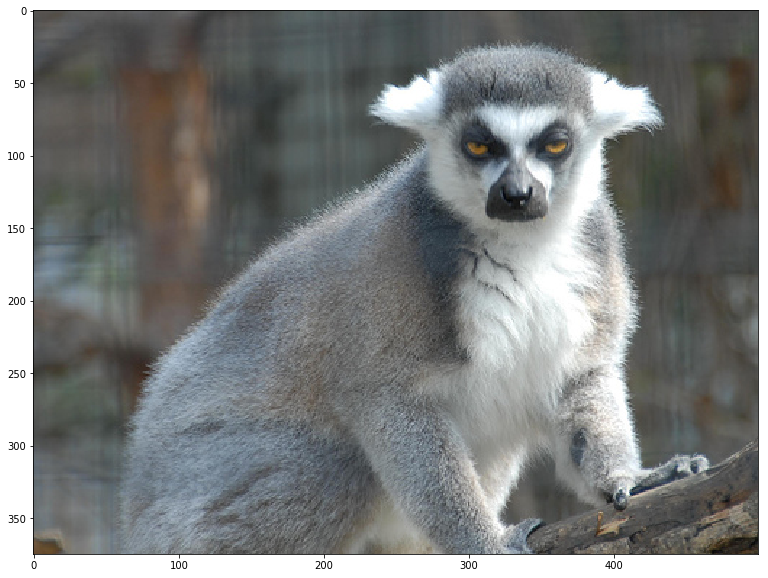

In [10]:
plt.imshow(image)

In [11]:
resized_image = resize(image, (224, 224), mode='wrap', preserve_range=True)
y = model.predict(np.expand_dims(resized_image, 0))

In [12]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [13]:
imagenet_utils.decode_predictions(y)

[[('n02497673', 'Madagascar_cat', 0.93312687),
  ('n02500267', 'indri', 0.062328555),
  ('n02493509', 'titi', 0.001560853),
  ('n02494079', 'squirrel_monkey', 0.00094206969),
  ('n02486261', 'patas', 0.00064214296)]]

In [14]:
def build_train_function(class_index = 0):
    # Получаем тензор, отвечающий за вход модели
    input_img = model.input
        
    # Выберем нужный слой
    predictions = model.output
    probabilities = K.softmax(predictions)
    objective = K.log(probabilities + 1e-8)[:,class_index]
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

In [15]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [15]:
def compute_image(train_function, img, max_iter = 50, lr = 1, epsilon = 5.0):
    input_img_data = img.copy()
    
    below = img - epsilon
    above = img + epsilon
    
    for i in range(max_iter):
        grads_value, objective_value = train_function([input_img_data])
        grads_value /= grads_value.std()+1e-8    
        input_img_data += grads_value * lr
        input_img_data = np.clip(np.clip(input_img_data, below, above), 0, 255)
        
        print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
    input_img_data = input_img_data[0]
    return input_img_data.astype(np.uint8)
#     return deprocess_image(input_img_data)

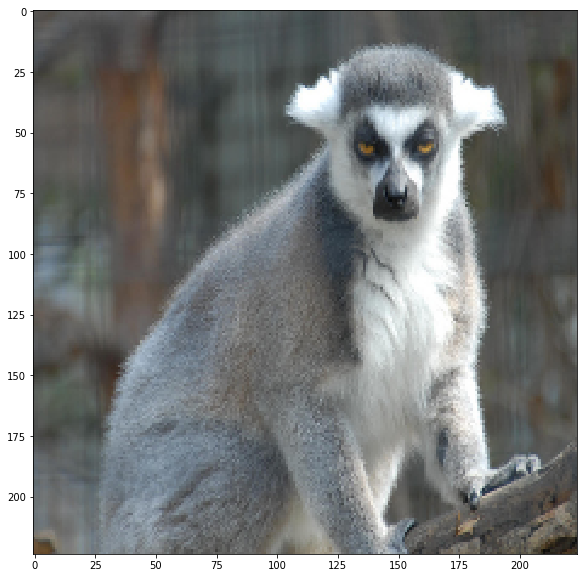

In [16]:
plt.imshow(resized_image.astype(np.uint8))

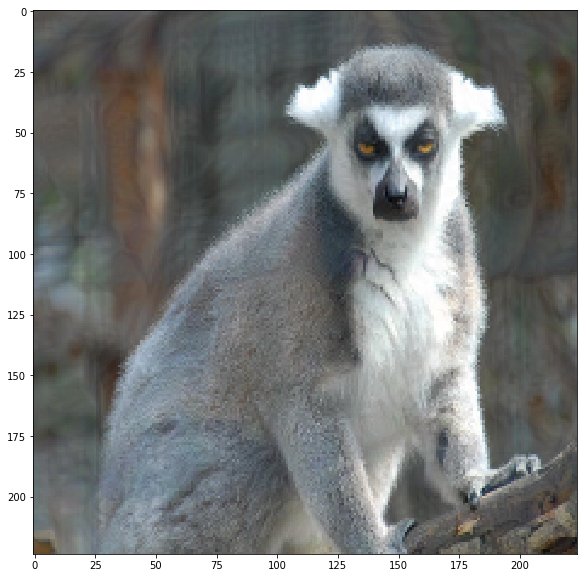

In [17]:
train_function = build_train_function(965)
img = compute_image(train_function, lr=1, img= np.expand_dims(resized_image, 0), epsilon=3.0)
plt.imshow(img)

In [18]:
y = model.predict(np.expand_dims(img, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.99999928),
  ('n07583066', 'guacamole', 2.002653e-07),
  ('n03887697', 'paper_towel', 1.4146261e-07),
  ('n07697537', 'hotdog', 1.0215935e-07),
  ('n07860988', 'dough', 7.9022321e-08)]]

In [19]:
from scipy.ndimage.interpolation import shift, rotate

In [20]:
rotated = rotate(img, np.degrees(np.pi/8), reshape=False)

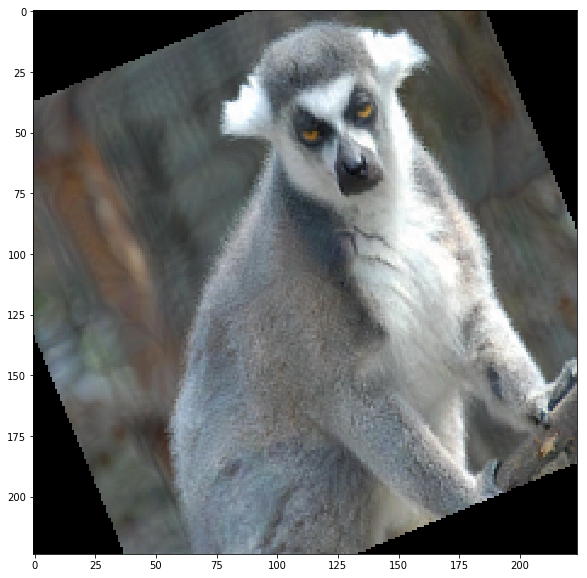

In [21]:
plt.imshow(rotated)

In [23]:
y = model.predict(np.expand_dims(rotated, 0))
imagenet_utils.decode_predictions(y)

[[('n02497673', 'Madagascar_cat', 0.3221018),
  ('n02138441', 'meerkat', 0.14815092),
  ('n03958227', 'plastic_bag', 0.083546251),
  ('n03887697', 'paper_towel', 0.078847989),
  ('n02500267', 'indri', 0.059838351)]]

In [24]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [25]:
def build_train_function_robust(class_index = 0, num_samples = 20):
    # Получаем тензор, отвечающий за вход модели
    input_img = K.placeholder(shape=(1, 224,224,3))
        
    # Выберем нужный слой
#     predictions = layer_dict['predictions'].output
#     probabilities = K.softmax(predictions)
    
    objectives = []
    for _ in range(num_samples):
        angle = K.random_uniform((), minval=-np.pi/4, maxval=np.pi/4)
        rotated = tf.contrib.image.rotate(input_img, angles=angle)
        output = model(rotated)
        probabilities = K.softmax(output)
        neg_xent = K.log(probabilities + 1e-8)[:,class_index]
        objectives.append(neg_xent)
        
    
    objective = K.mean(neg_xent)
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

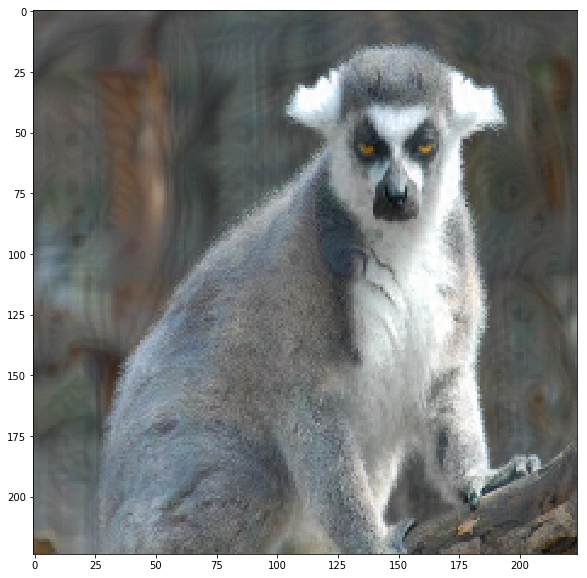

In [26]:
train_function = build_train_function_robust(965)
img = compute_image(train_function, lr=1, img= np.expand_dims(resized_image, 0), epsilon=3.5)
plt.imshow(img)

In [27]:
y = model.predict(np.expand_dims(img, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.99980336),
  ('n07860988', 'dough', 3.1419786e-05),
  ('n02100735', 'English_setter', 2.285657e-05),
  ('n07930864', 'cup', 2.0100686e-05),
  ('n02823750', 'beer_glass', 7.026847e-06)]]

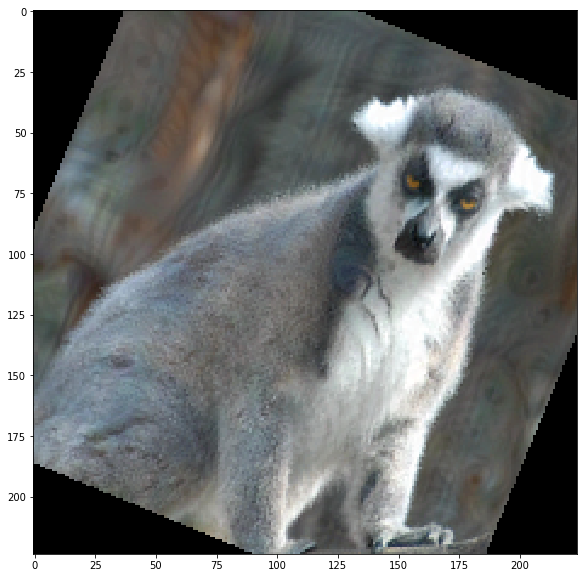

In [28]:
rotated = rotate(img, - np.degrees(np.pi/8), reshape=False)
plt.imshow(rotated)

In [29]:
y = model.predict(np.expand_dims(rotated, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.99999905),
  ('n07860988', 'dough', 2.9854493e-07),
  ('n07583066', 'guacamole', 1.6707961e-07),
  ('n03887697', 'paper_towel', 1.5175632e-07),
  ('n15075141', 'toilet_tissue', 5.9218621e-08)]]